# Final Project

In our final project, we chose to make a feline classifier, which will classify an image of a feline in one of four possible felines: lions, tigers, jaguars, and ocelots.


The project was made by **Bruno de Melo Costa** and **José Antônio Alves Maciel**. We use the code present in chapters 2 and 5 of the fast.ai Deep Learning course to make him.

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 11.4MB/s 
     |████████████████████████████████| 1.2MB 23.4MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 194kB 27.2MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 12.8MB 239kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

# Gathering Data

We’ll use Microsoft Azure to download our data from Bing Image Search. To do that, we create an account on Azure and get a key to use his web search engine.


In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '49f639aa69c9477e8ea81f427998d175')

Now let's use fastai's download_images to download all the URLs for each of our search terms, for our project, these are the scientific names for lions, tigers, jaguars and ocelots, respectively. We'll put each in a separate folder:

In [4]:
cats_names = 'Panthera leo','Panthera tigris','Panthera onca', 'Leopardus pardalis'
path = Path('cats')

In [5]:
if not path.exists():
    path.mkdir()
    for o in cats_names:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, o, 128, 300)
        download_images(dest, urls=results.attrgot('contentUrl'))

Our folder has image files, as we'd expect:


In [6]:
fns = get_image_files(path)
fns

(#547) [Path('cats/Leopardus pardalis/00000025.jpg'),Path('cats/Leopardus pardalis/00000144.jpg'),Path('cats/Leopardus pardalis/00000084.jpg'),Path('cats/Leopardus pardalis/00000040.jpg'),Path('cats/Leopardus pardalis/00000056.jpg'),Path('cats/Leopardus pardalis/00000036.jpg'),Path('cats/Leopardus pardalis/00000002.jpg'),Path('cats/Leopardus pardalis/00000009.jpg'),Path('cats/Leopardus pardalis/00000117.jpg'),Path('cats/Leopardus pardalis/00000114.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:



In [7]:
failed = verify_images(fns)
failed

(#2) [Path('cats/Leopardus pardalis/00000145.jpg'),Path('cats/Panthera leo/00000042.jpg')]

To remove all the failed images, you can use unlink on each of them. In our case, fortunately, we don’t have any corrupt image.

In [8]:
failed.map(Path.unlink);

Now that we already have our dataset, we must assemble it in a proper format so we can train our model. In fastai, that means creating an object called DataLoaders. 

In [9]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Now, we get the path where the images can be found:

In [10]:
dls = cats.dataloaders(path)

We can take a look at a few items of our batch by calling the show_batch method on a DataLoader:

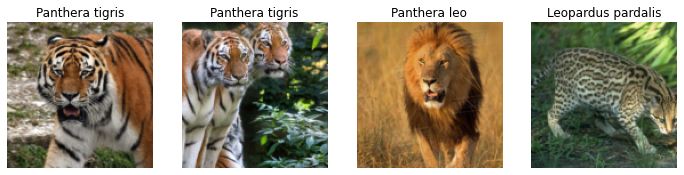

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

# Data Augmentation

Now, we'll perform data augmentation on our set to create random variations of the input data, because it helps to reflect how images work in the real world: different photos of the same thing may be framed in slightly different ways. This way, we'll be creating a more robust model.

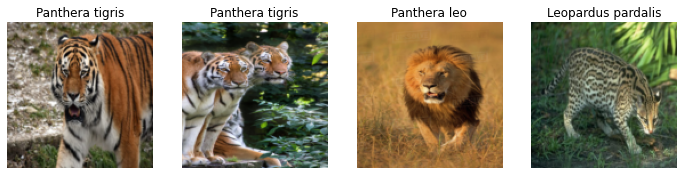

In [12]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

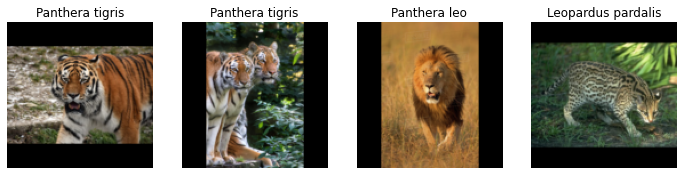

In [13]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

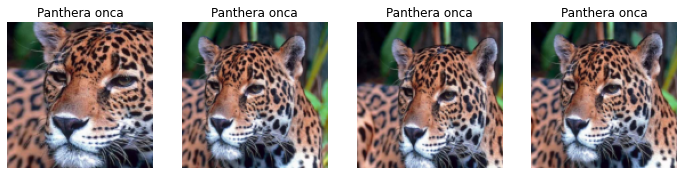

In [14]:
cats = cats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

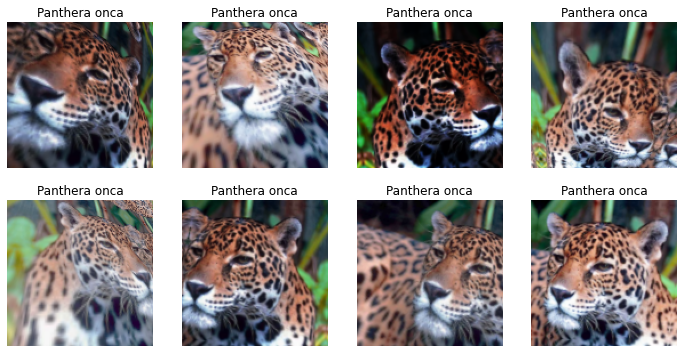

In [15]:
cats = cats.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training the Model

We don't have a lot of data for our problem, so to train our model, we'll use RandomResizedCrop with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms:

In [16]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats.dataloaders(path)

And we can create our Learner and fine-tune it using Chapter 5 techniques:

In [17]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


To visualize the kind of error that our model is doing, we can create a confusion matrix:

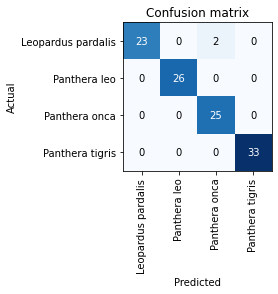

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Using plot_top_losses we'll visualize the images with the highest loss in our dataset:


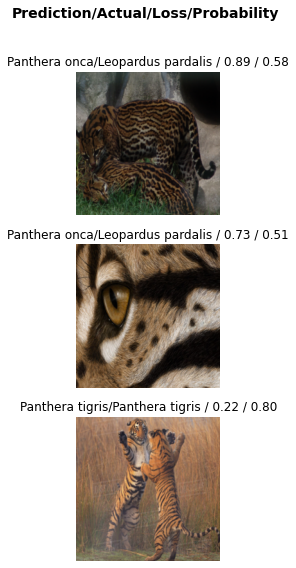

In [21]:
interp.plot_top_losses(3, nrows=3)

*fastai* includes a handy GUI for data cleaning called ImageClassifierCleaner that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [22]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Now, we can delete every image that we select to remove from our data


In [23]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

And also, relabeling those we want to change the category

In [24]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Once we have cleaned up our data, we can retrain our model.

# Using the Model for Inference

Now that we have a model we're happy with, we'll save it. For that, we'll use a Fastai's method called export that saves both architecture and parameters from the model.


In [25]:
learn.export()

Let's check that the file exists, by using the ls method that fastai adds to Python's Path class:


In [26]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

To create our inference learner from the exported file, we use load_learner


In [27]:
learn_inf = load_learner(path/'export.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to predict:

In [28]:
learn_inf.predict('/content/gdrive/MyDrive/Colab Notebooks/Images/Aslan2005.jpg')

('Panthera leo',
 tensor(1),
 tensor([1.0988e-09, 1.0000e+00, 8.3831e-12, 8.5293e-09]))

As expected, an image of Aslan, from The Chronicles of Narnia, was predicted as a lion with 1.0000e+00 probability.

# Creating a Notebook App from the Model

We'll use ipywidgets to build up our GUI and create a simple image classifier.
First, we need a file upload widget:


In [37]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

Now we can grab the image:

In [38]:
img = PILImage.create(btn_upload.data[-1])

We can use an Output widget to display it:

In [39]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

Then we can get our predictions:

In [40]:
pred,pred_idx,probs = learn_inf.predict(img)

and use a Label to display them:

In [41]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Panthera tigris; Probability: 0.9976')

We'll need a button to do the classification. It looks exactly like the upload button:


In [42]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

To deal with the Classify button, we'll build a click event handler; that is, a function that will be called when it's pressed:

In [43]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [44]:
btn_upload = widgets.FileUpload()

We'll now put them all in a vertical box (VBox) to complete our GUI:

In [45]:
VBox([widgets.Label('Select your Cat!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

And that's all! Hope you liked it, professor!